In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests


from lmmnn.utils import generate_data
from lmmnn.layers import NLL
from lmmnn.nn import reg_nn_lmm
from lmmnn.calc_b_hat import *

from keras.models import Sequential, Model
from keras.layers import Dense,LSTM,GRU,Dropout, Flatten, Input, ReLU
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as mse

from sklearn.metrics import mean_squared_error as mse

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_probability as tfp
import os



In [2]:
aPath = '--xla_gpu_cuda_data_dir=C:/Users/AndrejTschalzev/anaconda3/Library/bin'
print(aPath)
os.environ['XLA_FLAGS'] = aPath

tfd = tfp.distributions
tfb = tfp.bijectors

dtype = tf.float64

# %config InlineBackend.figure_format = 'retina'
# %matplotlib inline
plt.style.use('ggplot')

if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))



--xla_gpu_cuda_data_dir=C:/Users/AndrejTschalzev/anaconda3/Library/bin
SUCCESS: Found GPU: /device:GPU:0


## Generate Regression data

In [3]:
params = {
    "n_fixed_effects": 10,
    "fixed_intercept": 1,
    "X_non_linear": True,
    "Z_non_linear": False,
    "Z_embed_dim_pct": 10,
    "n_per_cat": 3,
    "test_size": 0.2,
}

# qs=[100,1000,10000] # use this if you want 3 z variables
# sig2bs=[0.1,1,10]

# datasets = {}
# for q in [100,1000,10000]:
#     for sig2b in [0.1,1,10]:
#         datasets[str(q)+"_"+str(sig2b)] = generate_data(mode='intercept', qs=[q], sig2e=1, sig2bs=[sig2b], sig2bs_spatial=[], q_spatial=[], N=100000, rhos=None, p_censor=None, params=params)#"./conf_files/conf_glmm.conf_glmm.yaml")


q = 100
sig2b = 1.0


X_train, X_test, y_train, y_test, x_cols, dist_matrix, time2measure_dict = generate_data(mode='intercepts', qs=[q], sig2e=1, sig2bs=[sig2b], sig2bs_spatial=[], q_spatial=[], N=100000, rhos=None, p_censor=None, params=params)#"./conf_files/conf_glmm.conf_glmm.yaml")

In [4]:
X_train.shape, len(x_cols)

((80000, 11), 10)

In [5]:
np.unique(X_train['z0'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [6]:
# Random Forest using 1 z variable

clf = RandomForestRegressor(random_state=0)
clf.fit(X_train, y_train)
y_pred_rf = clf.predict(X_test)
mse(y_test,y_pred_rf)

2.7057861787835793

In [7]:
# Random Forest using 1 z variable

clf = RandomForestRegressor(random_state=0)
clf.fit(X_train[x_cols], y_train)
y_pred_rf = clf.predict(X_test[x_cols])
mse(y_test,y_pred_rf)

2.757938853622694

In [8]:
model = Sequential()
model.add(Dense(100, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(1, activation='linear'))
model.compile(loss=tf.keras.losses.mean_squared_error, optimizer='adam', metrics=['mean_squared_error'])

model.fit(X_train[x_cols], y_train, epochs=500, batch_size=30, 
                 callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
                validation_data=(X_test[x_cols], y_test))
# Final evaluation of the model
scores = model.evaluate(X_test[x_cols], y_test, verbose=0)[0]
print("MSE: ", round(scores,2))

Epoch 1/500
2667/2667 [==============================] - 8s 3ms/step - loss: 2.9890 - mean_squared_error: 2.9890 - val_loss: 2.2494 - val_mean_squared_error: 2.2494
Epoch 2/500
2667/2667 [==============================] - 7s 3ms/step - loss: 2.3480 - mean_squared_error: 2.3480 - val_loss: 2.0103 - val_mean_squared_error: 2.0103
Epoch 3/500
2667/2667 [==============================] - 7s 3ms/step - loss: 2.1937 - mean_squared_error: 2.1937 - val_loss: 1.9549 - val_mean_squared_error: 1.9549
Epoch 4/500
2667/2667 [==============================] - 7s 3ms/step - loss: 2.1394 - mean_squared_error: 2.1394 - val_loss: 1.9527 - val_mean_squared_error: 1.9527
Epoch 5/500
2667/2667 [==============================] - 7s 3ms/step - loss: 2.1041 - mean_squared_error: 2.1041 - val_loss: 1.9320 - val_mean_squared_error: 1.9320
Epoch 6/500
2667/2667 [==============================] - 7s 3ms/step - loss: 2.0683 - mean_squared_error: 2.0683 - val_loss: 1.9338 - val_mean_squared_error: 1.9338
Epoch 7/50

In [9]:
model = Sequential()
model.add(Dense(100, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(12, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(1, activation='linear'))
model.compile(loss=tf.keras.losses.mean_squared_error, optimizer='adam', metrics=['mean_squared_error'])

model.fit(X_train[x_cols], y_train, epochs=500, batch_size=30, 
                 callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
                validation_data=(X_test[x_cols], y_test))
# Final evaluation of the model
scores = model.evaluate(X_test[x_cols], y_test, verbose=0)[0]
print("MSE: ", round(scores,2))

Epoch 1/500
2667/2667 [==============================] - 8s 3ms/step - loss: 3.1535 - mean_squared_error: 3.1535 - val_loss: 2.4163 - val_mean_squared_error: 2.4163
Epoch 2/500
2667/2667 [==============================] - 7s 3ms/step - loss: 2.5472 - mean_squared_error: 2.5472 - val_loss: 2.0958 - val_mean_squared_error: 2.0958
Epoch 3/500
2667/2667 [==============================] - 7s 3ms/step - loss: 2.3706 - mean_squared_error: 2.3706 - val_loss: 2.0841 - val_mean_squared_error: 2.0841
Epoch 4/500
2667/2667 [==============================] - 7s 3ms/step - loss: 2.2965 - mean_squared_error: 2.2965 - val_loss: 2.0240 - val_mean_squared_error: 2.0240
Epoch 5/500
2667/2667 [==============================] - 7s 3ms/step - loss: 2.2556 - mean_squared_error: 2.2556 - val_loss: 1.9886 - val_mean_squared_error: 1.9886
Epoch 6/500
2667/2667 [==============================] - 7s 3ms/step - loss: 2.2313 - mean_squared_error: 2.2313 - val_loss: 1.9803 - val_mean_squared_error: 1.9803
Epoch 7/50

In [10]:
# batch = 100
# epochs = 10
# patience = 10
qs=[q]#,1000,10000]
q_spatial=[]
# n_neurons = [10, 5, 2]
# dropout = None
# activation = 'relu'
# mode = 'glmm'
n_sig2bs = 1
n_sig2bs_spatial = 0
est_cors = []
# dist_matrix = None
# time2measure_dict = None
spatial_embed_neurons = None
verbose = True
Z_non_linear = False
# log_params = False
# idx = None
# Z_embed_dim_pct = 10
ls = None
sample_n_train=10000

In [11]:
# LMMNN using 3 z variables

mode = 'intercepts'
NUM_ITERATIONS = 1000
BATCH_SIZE = 30
LEARNING_RATE = 0.001
DECAY_RATE = 0.0001

X_input = Input(shape=(len(x_cols),))
y_true_input = Input(shape=(1,))
Z_input = Input(shape=(1,), dtype=tf.int64)
hidden1 = Dense(units=100, activation='relu', input_dim=len(x_cols))(X_input)
dropout1 = Dropout(.25)(hidden1)
hidden2 = Dense(units=50, activation='relu', input_dim=len(x_cols))(dropout1)
dropout2 = Dropout(.25)(hidden2)
y_pred_output = Dense(units=1, activation='linear')(dropout2)
nll = NLL(mode, 1.0, [1.0])(y_true_input, y_pred_output, [Z_input])
model = Model(inputs=[X_input, y_true_input, Z_input], outputs=nll)

adam = Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=None, decay=DECAY_RATE, amsgrad=False)
model.compile(optimizer = adam)
# X_train.reset_index(inplace=True)
# X_train.sort_values(by=['z0'], inplace=True)
# y_train = y_train[X_train.index]

history = model.fit([X_train[x_cols], y_train, X_train['z0']], None, batch_size=BATCH_SIZE, epochs=200, callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
                    validation_data=[[X_test[x_cols], y_test, X_test['z0']]], shuffle=True)

Epoch 1/200
2667/2667 [==============================] - 13s 5ms/step - loss: 60.1139 - val_loss: 54.9271
Epoch 2/200
2667/2667 [==============================] - 12s 5ms/step - loss: 55.1578 - val_loss: 52.7201
Epoch 3/200
2667/2667 [==============================] - 12s 5ms/step - loss: 53.9630 - val_loss: 52.3104
Epoch 4/200
2667/2667 [==============================] - 13s 5ms/step - loss: 53.4352 - val_loss: 52.0039
Epoch 5/200
2667/2667 [==============================] - 12s 5ms/step - loss: 53.2211 - val_loss: 51.9322
Epoch 6/200
2667/2667 [==============================] - 19s 7ms/step - loss: 53.0688 - val_loss: 51.8764
Epoch 7/200
2667/2667 [==============================] - 22s 8ms/step - loss: 53.0492 - val_loss: 51.9183
Epoch 8/200
2667/2667 [==============================] - 22s 8ms/step - loss: 52.8465 - val_loss: 51.8009
Epoch 9/200
2667/2667 [==============================] - 17s 7ms/step - loss: 52.8784 - val_loss: 51.8294
Epoch 10/200
2667/2667 [======================

In [12]:
sig2e_est, sig2b_ests, rho_ests, weibull_ests = model.layers[-1].get_vars()
sig2b_spatial_ests = []
z_cols = sorted(X_train.columns[X_train.columns.str.startswith('z')].tolist())
X_train_z_cols = [X_train[z_col] for z_col in z_cols]
X_test_z_cols = [X_test[z_col] for z_col in z_cols]
y_pred_tr = model.predict([X_train[x_cols], y_train] + X_train_z_cols).reshape(X_train.shape[0])

b_hat = calc_b_hat(X_train, y_train, y_pred_tr, qs, q_spatial, sig2e_est, sig2b_ests, sig2b_spatial_ests,
    Z_non_linear, model, ls, mode, rho_ests, est_cors, dist_matrix, weibull_ests, sample_n_train)
dummy_y_test = np.random.normal(size=y_test.shape)
dummy_y_train = np.random.normal(size=y_train.shape)

y_pred = model.predict([X_test[x_cols], dummy_y_test] + X_test_z_cols).reshape(
            X_test.shape[0]) + b_hat[X_test['z0']]
y_pred_fe = model.predict([X_test[x_cols], dummy_y_test] + X_test_z_cols).ravel()

y_train_pred = model.predict([X_train[x_cols], dummy_y_train] + X_train_z_cols).reshape(
            X_train.shape[0]) + b_hat[X_train['z0']]
y_train_pred_fe = model.predict([X_train[x_cols], dummy_y_train] + X_train_z_cols).ravel()


mse(y_pred,y_test),mse(y_pred_fe,y_test)

(1.0683825444980333, 1.8825050279507711)

In [14]:
print("Train MSE: ", mse(y_train, y_train_pred))
print("Train MSE (only FE): ", mse(y_train, y_train_pred_fe))
print("Test MSE: ", mse(y_test, y_pred))
print("Test MSE (only FE): ", mse(y_test, y_pred_fe))

z_available = np.unique(np.append(X_train["z0"].values,X_test["z0"].values))
z0_mean_ratings = pd.DataFrame([np.append(X_train["z0"].values,X_test["z0"].values),np.append(y_train,y_test)]).transpose().groupby(0).mean().values.ravel()
print("Correlation mean z0/raneffs: ", np.corrcoef([z0_mean_ratings, b_hat[z_available]])[0,1])


Train MSE:  1.0597270702394823
Train MSE (only FE):  1.8549745642466142
Test MSE:  1.0683825444980333
Test MSE (only FE):  1.8825050279507711
Correlation mean z0/raneffs:  0.9979889114464384


## MENN

In [15]:
get_value = lambda dataframe, key, dtype: dataframe[key].values.astype(dtype)
features_train = {
    k: get_value(X_train, key=k, dtype=np.float32)
    for k in X_train.columns}
fe_features = x_cols
labels_train = y_train

features_test = {k: get_value(X_test, key=k, dtype=np.float32)
                 for k in X_test.columns}
labels_test = y_test


num_z0 = q


In [20]:
initializer = tf.keras.initializers.GlorotUniform(seed=42)


###### Define Model #############
class LinearMixedEffectModel(tf.Module):
    def __init__(self):
    # Set up fixed effects and other parameters.
    # These are free parameters to be optimized in E-steps
    # self._intercept = tf.Variable(0., name="intercept")            # alpha in eq
    # self._fixed_effects = tf.Variable([0.]*len(fe_features), name="fixed effects")  #  beta in eq
    # self.l1 = Dense(10, input_dim=3, activation="relu")
    # self.l2 = Dense(3, input_dim=3, activation="relu")
    # self.out_ = Dense(1, input_dim=3, activation="linear")
    # self.out_ = tfp.layers.DenseVariational(1, activation="relu")

        self.l1 = tf.Variable(initializer([len(fe_features),100]), name="l1", dtype=tf.float32)
        self.l1_bias = tf.Variable(initializer([100]), name="l1", dtype=tf.float32)
        self.l2 = tf.Variable(initializer([100,50]), name="l2", dtype=tf.float32)
        self.l2_bias = tf.Variable(initializer([50]), name="l2", dtype=tf.float32)
        self.out = tf.Variable(initializer([50]), name="out", dtype=tf.float32)
        self.out_bias = tf.Variable(initializer([1]), name="out", dtype=tf.float32)


        self._stddev_z0 = tfp.util.TransformedVariable(
            1., bijector=tfb.Exp(), name="stddev_z0")            # sigma in eq

    def NN_forward(self, features):
        feature_tensor = tf.transpose(tf.convert_to_tensor([features[feat] for feat in fe_features], dtype=tf.float32))
#         return tf.linalg.matvec(tf.nn.dropout(0.25)(ReLU()(tf.linalg.matmul(tf.nn.dropout(0.25)(ReLU()(tf.linalg.matmul(feature_tensor, self.l1) + self.l1_bias)), self.l2) + self.l2_bias)), self.out) + self.out_bias
        return tf.linalg.matvec(ReLU()(tf.linalg.matmul(ReLU()(tf.linalg.matmul(feature_tensor, self.l1) + self.l1_bias), self.l2) + self.l2_bias), self.out) + self.out_bias

    def __call__(self, features):
        feature_tensor = tf.transpose(tf.convert_to_tensor([features[feat] for feat in fe_features], dtype=tf.float32))

        model = tfd.JointDistributionSequentialAutoBatched([
          # Set up random effects.
          tfd.MultivariateNormalDiag(
              loc=tf.zeros(num_z0),
              scale_identity_multiplier=self._stddev_z0),
          # This is the likelihood for the observed.
          lambda effect_z0: tfd.Independent(
              tfd.Normal(
                  loc=(tf.linalg.matvec(ReLU()(tf.linalg.matmul(ReLU()(tf.linalg.matmul(feature_tensor, self.l1) + self.l1_bias), self.l2) + self.l2_bias), self.out) + self.out_bias +
                      tf.gather(effect_z0, features["z0"].astype(int), axis=-1) 
                      ),
                  scale=1.),
                  reinterpreted_batch_ndims=1)
        ])

        # To enable tracking of the trainable variables via the created distribution,
        # we attach a reference to `self`. Since all TFP objects sub-class
        # `tf.Module`, this means that the following is possible:
        # LinearMixedEffectModel()(features_train).trainable_variables
        # ==> tuple of all tf.Variables created by LinearMixedEffectModel.
        model._to_track = self
        return model

In [21]:
lmm_jointdist = LinearMixedEffectModel()
# Conditioned on feature/predictors from the training data
lmm_train = lmm_jointdist(features_train)
lmm_test = lmm_jointdist(features_test)


# Parameter Estimation
target_log_prob_fn = lambda *x: lmm_train.log_prob(x + (labels_train,))
target_log_prob_test_fn = lambda *x: lmm_test.log_prob(x + (labels_test,))
trainable_variables = lmm_train.trainable_variables
current_state = lmm_train.sample()[:-1]

# For debugging
target_log_prob_fn(*current_state)

<tf.Tensor: shape=(), dtype=float32, numpy=-276240.0>

In [22]:
# Set up E-step (MCMC).
hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,
    step_size=0.005,
    num_leapfrog_steps=3)
kernel_results = hmc.bootstrap_results(current_state)

@tf.function(autograph=False, jit_compile=True)
def one_e_step(current_state, kernel_results):
  next_state, next_kernel_results = hmc.one_step(
      current_state=current_state,
      previous_kernel_results=kernel_results)
  return next_state, next_kernel_results

optimizer = tf.optimizers.Adam(learning_rate=.01)#, decay=0.0001)

# Set up M-step (gradient descent).
@tf.function(autograph=False, jit_compile=True)
def one_m_step(current_state):
  with tf.GradientTape() as tape:
    loss = -target_log_prob_fn(*current_state)
  grads = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(grads, trainable_variables))
  return loss


In [23]:
# Warm-up
num_warmup_iters = 1000
num_iters = 20000
num_accepted = 0
effect_z0_samples = []#np.zeros([num_iters, num_hosts])
loss_history = np.zeros([num_iters])

# Run warm-up stage.
for t in range(num_warmup_iters):
  current_state, kernel_results = one_e_step(current_state, kernel_results)
  num_accepted += kernel_results.is_accepted.numpy()
  if t % 500 == 0 or t == num_warmup_iters - 1:
    print("Warm-Up Iteration: {:>3} Acceptance Rate: {:.3f}".format(
        t, num_accepted / (t + 1)))

num_accepted = 0  # reset acceptance rate counter

test_log_prob = []
# Run training.
for t in range(num_iters):
  # run 5 MCMC iterations before every joint EM update
  for _ in range(5):
    current_state, kernel_results = one_e_step(current_state, kernel_results)
  if t==0:
      curr_test_prob = -target_log_prob_test_fn(*current_state).numpy()
      test_log_prob.append(curr_test_prob)

  loss = one_m_step(current_state)
  effect_z0_samples.append(current_state[0].numpy())
  num_accepted += kernel_results.is_accepted.numpy()

  # if np.all(loss_history[-10:] > loss.numpy()):
  #   print("Early stopping at iteration {}".format(t))
  #   print("Iteration: {:>4} Acceptance Rate: {:.3f} Loss: {:.3f}".format(
  #       t, num_accepted / (t + 1), loss_history[t]))
  #
  #   break

  loss_history[t] = loss.numpy()

  if t % 500 == 0 or t == num_iters - 1:
    print("Iteration: {:>4} Acceptance Rate: {:.3f} Loss: {:.3f}".format(
        t, num_accepted / (t + 1), loss_history[t]))



  if t % 1000 == 0 or t == num_iters - 1:


      [
          effect_z0_mean,
      ] = [
          np.mean(x, axis=0).astype(np.float32) for x in [
              effect_z0_samples
          ]
      ]

      # Get the posterior predictive train distribution
      (*posterior_conditionals_train, ratings_posterior_train), _ = lmm_train.sample_distributions(
          value=(
              effect_z0_mean,
          ))

      ratings_prediction_train = ratings_posterior_train.mean()

      # Get the posterior predictive test distribution
      (*posterior_conditionals_test, ratings_posterior_test), _ = lmm_test.sample_distributions(
          value=(
              effect_z0_mean,
          ))

      ratings_prediction_test = ratings_posterior_test.mean()

      print("Iteration: {:>4} Performance".format(t))
      print("Train MSE: ", mse(labels_train, ratings_prediction_train))
      print("Test MSE: ", mse(labels_test, ratings_prediction_test))

      curr_test_prob = -target_log_prob_test_fn(*current_state).numpy()
      print("Test NLL: ", curr_test_prob)
      test_log_prob.append(curr_test_prob)

#       if test_log_prob[-2]<curr_test_prob:
#         print("Early stopping at iteration {} with test NLL={}".format(t, curr_test_prob))

#         break



Warm-Up Iteration:   0 Acceptance Rate: 1.000
Warm-Up Iteration: 500 Acceptance Rate: 0.990
Warm-Up Iteration: 999 Acceptance Rate: 0.989
Iteration:    0 Acceptance Rate: 1.000 Loss: 214229.469
Iteration:    0 Performance
Train MSE:  3.2112260965116435
Test MSE:  3.1824956103944473
Test NLL:  50343.164
Iteration:  500 Acceptance Rate: 0.806 Loss: 113071.688
Iteration: 1000 Acceptance Rate: 0.541 Loss: 112710.438
Iteration: 1000 Performance
Train MSE:  0.9736124753917073
Test MSE:  1.0064378728880758
Test NLL:  28601.55
Iteration: 1500 Acceptance Rate: 0.392 Loss: 112662.188
Iteration: 2000 Acceptance Rate: 0.322 Loss: 112244.336
Iteration: 2000 Performance
Train MSE:  0.9674923376862913
Test MSE:  1.0187030031452171
Test NLL:  28705.324
Iteration: 2500 Acceptance Rate: 0.277 Loss: 112017.773
Iteration: 3000 Acceptance Rate: 0.244 Loss: 111909.195
Iteration: 3000 Performance
Train MSE:  0.9556022506282641
Test MSE:  1.02027124582584
Test NLL:  28722.459
Iteration: 3500 Acceptance Rate: 

KeyboardInterrupt: 

In [24]:
effect_z0_samples = np.array(effect_z0_samples)


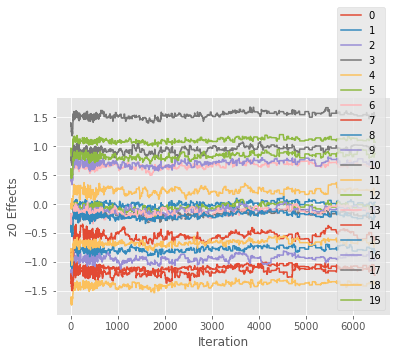

In [25]:
plt.style.use('ggplot')
# Effect transitions for first k effects
k = 20
for i in range(k):
  plt.plot(effect_z0_samples[:, 10+i])

plt.legend([i for i in range(k)], loc='lower right')
plt.ylabel('z0 Effects')
plt.xlabel('Iteration')
plt.show()

In [26]:
# Get probabilities
lmm_test = lmm_jointdist(features_test)

[
    effect_z0_mean,
] = [
     np.mean(x, axis=0).astype(np.float32) for x in [
       effect_z0_samples[500:]
       ]
]

# Get the posterior predictive train distribution
(*posterior_conditionals_train, ratings_posterior_train), _ = lmm_train.sample_distributions(
    value=(
        effect_z0_mean,
))

(*posterior_conditionals_fe_train, ratings_posterior_fe_train), _ = lmm_train.sample_distributions(
    value=(
        np.array([0]*len(effect_z0_mean)),
))


ratings_prediction_train = ratings_posterior_train.mean()
ratings_prediction_fe_train = ratings_posterior_fe_train.mean()

# Alternative für Fixed Effect Predictions
# y_FE = lmm_jointdist.NN_forward(features_train)

# Get the posterior predictive test distribution
(*posterior_conditionals_test, ratings_posterior_test), _ = lmm_test.sample_distributions(
    value=(
        effect_z0_mean,
))

(*posterior_conditionals_fe_test, ratings_posterior_fe_test), _ = lmm_test.sample_distributions(
    value=(
        np.array([0]*len(effect_z0_mean)),
        ))


ratings_prediction_test = ratings_posterior_test.mean()
ratings_prediction_fe_test = ratings_posterior_fe_test.mean()

print("Train MSE: ", mse(labels_train, ratings_prediction_train))
print("Train MSE (only FE): ", mse(labels_train, ratings_prediction_fe_train))
print("Test MSE: ", mse(labels_test, ratings_prediction_test))
print("Test MSE (only FE): ", mse(labels_test, ratings_prediction_fe_test))

z_available = np.unique(np.append(X_train["z0"].values,X_test["z0"].values))
z0_mean_ratings = pd.DataFrame([np.append(X_train["z0"].values,X_test["z0"].values),np.append(y_train,y_test)]).transpose().groupby(0).mean().values.ravel()
print("Correlation mean z0/raneffs: ", np.corrcoef([z0_mean_ratings, effect_z0_mean[z_available]])[0,1])


Train MSE:  0.9495045179421934
Train MSE (only FE):  1.7657677207616997
Test MSE:  1.036058219152889
Test MSE (only FE):  1.8600452316276561
Correlation mean z0/raneffs:  0.9977465454628668


In [87]:
x_cols = [col for col in X_train.columns if col not in ['z0','z1','z2']]
batch = 100
epochs = 10
patience = 10
qs=[100]#,1000,10000]
q_spatial=[]
n_neurons = [10, 5, 2]
dropout = None
activation = 'relu'
mode = 'glmm'
n_sig2bs = 1
n_sig2bs_spatial = 0
est_cors = []
dist_matrix = None
time2measure_dict = None
spatial_embed_neurons = None
verbose = True
Z_non_linear = False
log_params = False
idx = None
Z_embed_dim_pct = 10


In [88]:
# simple
n_neurons = [5]
y_pred, sigmas, rhos, weibull, n_epochs = reg_nn_lmm(
            X_train, X_test, y_train, y_test, qs, q_spatial, x_cols, batch, epochs, patience,
            n_neurons, dropout, activation, mode,
            n_sig2bs, n_sig2bs_spatial, est_cors, dist_matrix, spatial_embed_neurons, verbose, Z_non_linear, Z_embed_dim_pct, log_params, idx)

Epoch 1/10
720/720 [==============================] - 4s 6ms/step - loss: 67.0956 - val_loss: 65.0391
Epoch 2/10
720/720 [==============================] - 3s 4ms/step - loss: 64.4057 - val_loss: 63.5360
Epoch 3/10
720/720 [==============================] - 4s 5ms/step - loss: 63.0351 - val_loss: 62.5357
Epoch 4/10
720/720 [==============================] - 4s 5ms/step - loss: 62.3010 - val_loss: 62.1152
Epoch 5/10
720/720 [==============================] - 4s 5ms/step - loss: 61.9573 - val_loss: 61.9300
Epoch 6/10
720/720 [==============================] - 4s 6ms/step - loss: 61.7883 - val_loss: 61.8486
Epoch 7/10
720/720 [==============================] - 4s 6ms/step - loss: 61.7039 - val_loss: 61.8190
Epoch 8/10
720/720 [==============================] - 5s 7ms/step - loss: 61.6554 - val_loss: 61.7972
Epoch 9/10
720/720 [==============================] - 4s 6ms/step - loss: 61.6223 - val_loss: 61.7755
Epoch 10/10
720/720 [==============================] - 4s 6ms/step - loss: 61.5933

In [90]:
# round predictions to closest integer
y_pred_class = []
for n in y_pred:
    y_pred_class.append(round(n))

accuracy_score(y_test, y_pred_class)

0.65925

In [43]:
# more complex
y_pred, sigmas, rhos, weibull, n_epochs = reg_nn_lmm(
            X_train, X_test, y_train, y_test, qs, q_spatial, x_cols, batch, epochs, patience,
            n_neurons, dropout, activation, mode,
            n_sig2bs, n_sig2bs_spatial, est_cors, dist_matrix, spatial_embed_neurons, verbose, Z_non_linear, Z_embed_dim_pct, log_params, idx)

Epoch 1/10
720/720 [==============================] - 4s 6ms/step - loss: 67.9445 - val_loss: 66.3830
Epoch 2/10
720/720 [==============================] - 4s 5ms/step - loss: 63.2507 - val_loss: 62.3688
Epoch 3/10
720/720 [==============================] - 4s 5ms/step - loss: 61.0069 - val_loss: 60.9193
Epoch 4/10
720/720 [==============================] - 4s 5ms/step - loss: 60.0911 - val_loss: 60.2229
Epoch 5/10
720/720 [==============================] - 4s 5ms/step - loss: 59.4728 - val_loss: 59.5839
Epoch 6/10
720/720 [==============================] - 4s 5ms/step - loss: 58.8078 - val_loss: 58.7403
Epoch 7/10
720/720 [==============================] - 4s 5ms/step - loss: 58.1545 - val_loss: 58.2428
Epoch 8/10
720/720 [==============================] - 4s 5ms/step - loss: 57.8414 - val_loss: 58.0293
Epoch 9/10
720/720 [==============================] - 4s 5ms/step - loss: 57.6636 - val_loss: 57.8732
Epoch 10/10
720/720 [==============================] - 4s 6ms/step - loss: 57.5537

In [44]:
y_pred

array([0.30334791, 0.32082577, 0.2263784 , ..., 0.13376543, 0.52185211,
       0.153196  ])

In [45]:
y_test

91505    1
42340    0
19847    0
22940    1
39723    0
        ..
15236    1
22404    0
13079    1
31917    0
6239     0
Name: y, Length: 20000, dtype: int32

In [46]:
len(y_pred) == len(y_test)

True

In [52]:
# round predictions to closest integer
y_pred_class = []
for n in y_pred:
    y_pred_class.append(round(n))

y_pred_class

[0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [54]:
accuracy_score(y_test, y_pred_class)

0.70115